<h1><center>Planet Classification using Kepler Data</center></h1>

<img src="./figures/intro_sun.jpg" width="300" hspace="20"/>
<img src="./figures/transit.jpg" width="300" hspace="20"/>


*Kepler (2009 - 2018) was NASA Space Telescope with two missions (K1, K2) which identified potential planets outside of our solar system. It looked for dips in stars' brightness which indicated a planet passing in front of the star. According to Kepler data, on average, every star has more than one planet. Kepler (K1) looked at 150,000 stars and identified 2300 confirmed planets. K2 identified about planets. From the dips Kepler conmputed the mass and radius of the potential planet.* 

columns headings:https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html

#### First, we need to install the python library which interfaces with the Kepler API. This builds and makes the api calls for us. 

In [1]:
# !pip install kplr
# !pip install pyfits

#### Import libraries and set up client side. 

In [2]:
import kplr
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from sklearn.metrics import classification_report, confusion_matrix , accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from patsy import dmatrices
import statsmodels.api as sm
import seaborn as sns
import itertools

import warnings
warnings.filterwarnings('ignore')

/anaconda3/envs/learn-env/lib/python3.6/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
client = kplr.API()

#### Make a call to the NASA server to grab a single planet. Print the orbital period in days.

In [5]:
# Calling for a planet named 952.01
koi = client.koi(977.01)
print(koi.koi_period)

1.353771892


In [6]:
lcs = koi.get_light_curves(short_cadence=False)

In [7]:
# Loop over the datatset and read in the data

time, flux, ferr, quality = [], [], [], []
for lc in lcs:
    with lc.open() as f:
        #the lightcurve data are in the first FITS HDU.
        hdu_data = f[1].data
        time.append(hdu_data['time'])
        flux.append(hdu_data['sap_flux'])
        ferr.append(hdu_data['sap_flux_err'])
        quality.append(hdu_data['sap_quality'])

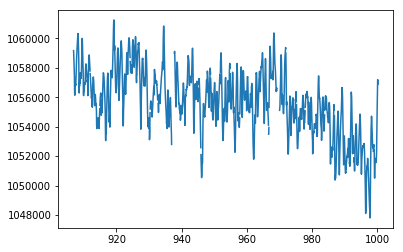

In [8]:
# Raw light curve
plt.plot(time[10], flux[10])

In [9]:
len(time)

18

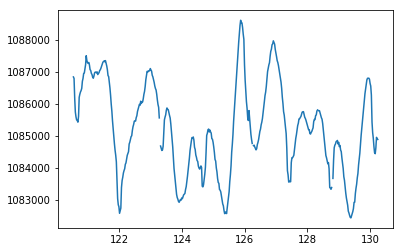

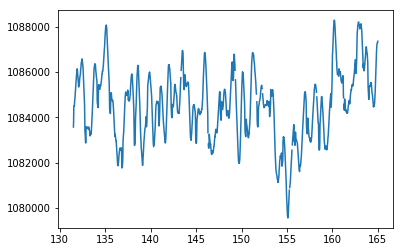

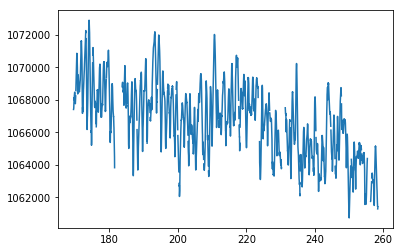

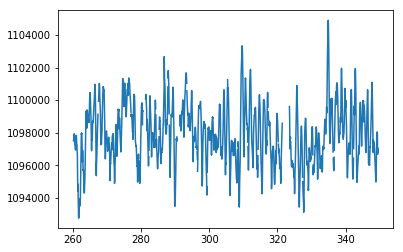

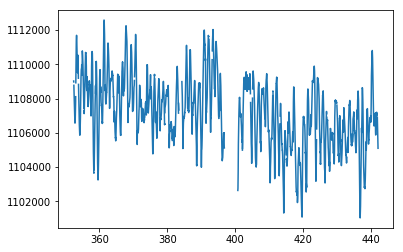

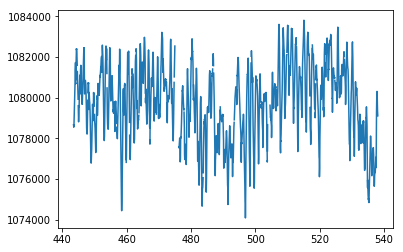

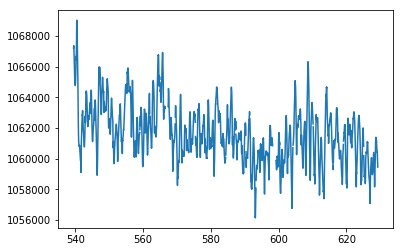

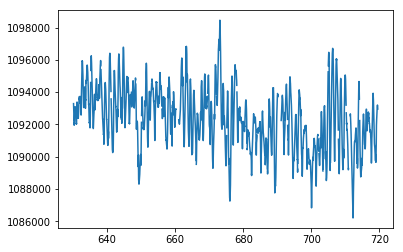

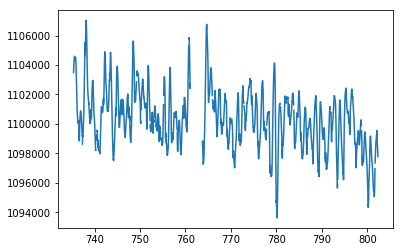

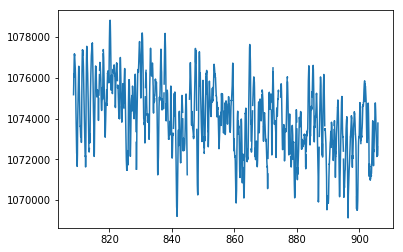

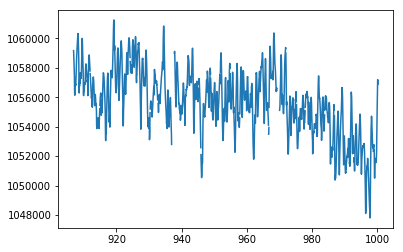

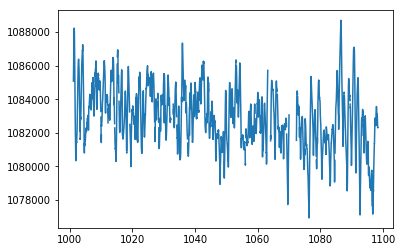

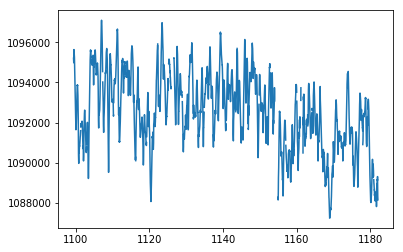

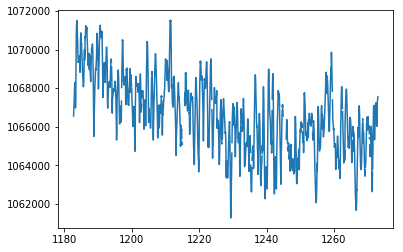

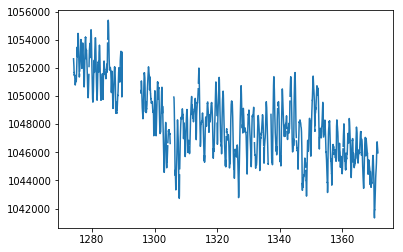

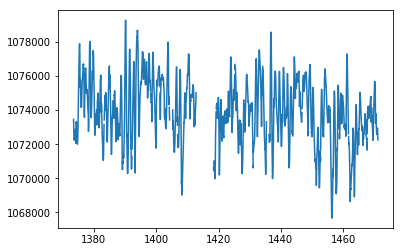

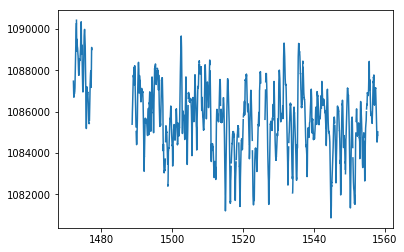

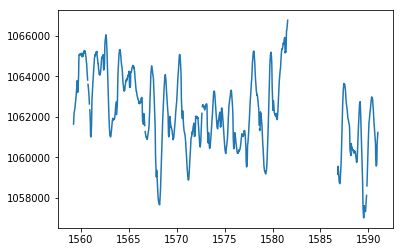

In [10]:
for t, f in zip(time, flux):
    plt.figure()
    plt.plot(t, f)

https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=cumulative&where=koi_prad<2 and koi_teq>180 and koi_teq<303 and koi_disposition like 'CANDIDATE'

In [11]:
# Planets smaller than the size of Earth 
small_planets = client.kois(where="koi_prad<1")


In [12]:
# Planets greater than the size of Earth
big_planets = client.kois(where="koi_prad>1")

In [13]:
# dir(koi)

In [14]:
# dir(small_planets[0])

In [15]:
df = pd.read_csv('kepler.csv')
df.head()

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [16]:
df.columns

Index(['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_disposition',
       'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss',
       'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_period_err1',
       'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1',
       'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2',
       'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth',
       'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1',
       'koi_prad_err2', 'koi_teq', 'koi_teq_err1', 'koi_teq_err2', 'koi_insol',
       'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_tce_plnt_num',
       'koi_tce_delivname', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2',
       'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad',
       'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec', 'koi_kepmag'],
      dtype='object')

In [17]:
df.koi_disposition.value_counts()

FALSE POSITIVE    5023
CONFIRMED         2293
CANDIDATE         2248
Name: koi_disposition, dtype: int64

In [18]:
# Let's drop names since those won't matter in our predictions

kepler = df.drop(columns=['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_disposition','koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec'])


In [19]:
kepler.head()

,koi_pdisposition,koi_score,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,CANDIDATE,1.000,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,CANDIDATE,0.969,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,FALSE POSITIVE,0.000,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,FALSE POSITIVE,0.000,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,CANDIDATE,1.000,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [20]:
# df.koi_pdisposition.value_counts()

In [21]:
# Rename the koi_disposition to say target
kepler.rename(columns={'koi_pdisposition':'target'},inplace = True)
kepler.head()

,target,koi_score,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,CANDIDATE,1.000,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,CANDIDATE,0.969,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,FALSE POSITIVE,0.000,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,FALSE POSITIVE,0.000,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,CANDIDATE,1.000,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [22]:
kepler['target'].replace(['FALSE POSITIVE','CANDIDATE'],[0,1],inplace=True)

In [23]:
kepler.head()

,target,koi_score,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,1.000,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,1,0.969,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,0,0.000,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,0,0.000,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,1,1.000,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [24]:
kepler.columns[kepler.isna().any()].tolist()

['koi_score',
 'koi_period_err1',
 'koi_period_err2',
 'koi_time0bk_err1',
 'koi_time0bk_err2',
 'koi_impact',
 'koi_impact_err1',
 'koi_impact_err2',
 'koi_duration_err1',
 'koi_duration_err2',
 'koi_depth',
 'koi_depth_err1',
 'koi_depth_err2',
 'koi_prad',
 'koi_prad_err1',
 'koi_prad_err2',
 'koi_teq',
 'koi_teq_err1',
 'koi_teq_err2',
 'koi_insol',
 'koi_insol_err1',
 'koi_insol_err2',
 'koi_model_snr',
 'koi_tce_plnt_num',
 'koi_tce_delivname',
 'koi_steff',
 'koi_steff_err1',
 'koi_steff_err2',
 'koi_slogg',
 'koi_slogg_err1',
 'koi_slogg_err2',
 'koi_srad',
 'koi_srad_err1',
 'koi_srad_err2',
 'koi_kepmag']

In [25]:
kepler.isna().sum(axis=0)

target                  0
koi_score            1510
koi_period              0
koi_period_err1       454
koi_period_err2       454
koi_time0bk             0
koi_time0bk_err1      454
koi_time0bk_err2      454
koi_impact            363
koi_impact_err1       454
koi_impact_err2       454
koi_duration            0
koi_duration_err1     454
koi_duration_err2     454
koi_depth             363
koi_depth_err1        454
koi_depth_err2        454
koi_prad              363
koi_prad_err1         363
koi_prad_err2         363
koi_teq               363
koi_teq_err1         9564
koi_teq_err2         9564
koi_insol             321
koi_insol_err1        321
koi_insol_err2        321
koi_model_snr         363
koi_tce_plnt_num      346
koi_tce_delivname     346
koi_steff             363
koi_steff_err1        468
koi_steff_err2        483
koi_slogg             363
koi_slogg_err1        468
koi_slogg_err2        468
koi_srad              363
koi_srad_err1         468
koi_srad_err2         468
ra          

Things to drop:
1. koi_score
2. All of the error columns -- because we're trying to keep things simple for now
3. koi_tce_delivname -- `['q1_q17_dr25_tce', 'q1_q16_tce', nan, 'q1_q17_dr24_tce']`. Represents meta-data, not a physical measurement/paramater
4. koi_model_snr -- transit depth, normalized by uncertainty. Information we won't use yet
5. koi_tce_plnt_num -- another ID.



In [26]:
kepler.columns

Index(['target', 'koi_score', 'koi_period', 'koi_period_err1',
       'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1',
       'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2',
       'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth',
       'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1',
       'koi_prad_err2', 'koi_teq', 'koi_teq_err1', 'koi_teq_err2', 'koi_insol',
       'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_tce_plnt_num',
       'koi_tce_delivname', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2',
       'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad',
       'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec', 'koi_kepmag'],
      dtype='object')

In [27]:
cols_to_keep = [
    'target', 'koi_period', 'koi_time0bk',
    'koi_impact', 'koi_duration', 'koi_depth', 'koi_prad',
    'koi_teq', 'koi_insol','koi_steff', 'koi_slogg',
    'koi_srad', 'ra', 'dec', 'koi_kepmag'
]



In [28]:
df = kepler[cols_to_keep]

In [29]:
df.head()

,target,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_steff,koi_slogg,koi_srad,ra,dec,koi_kepmag
0,1,9.488036,170.538750,0.146,2.95750,615.8,2.26,793.0,93.59,5455.0,4.467,0.927,291.93423,48.141651,15.347
1,1,54.418383,162.513840,0.586,4.50700,874.8,2.83,443.0,9.11,5455.0,4.467,0.927,291.93423,48.141651,15.347
2,0,19.899140,175.850252,0.969,1.78220,10829.0,14.60,638.0,39.30,5853.0,4.544,0.868,297.00482,48.134129,15.436
3,0,1.736952,170.307565,1.276,2.40641,8079.2,33.46,1395.0,891.96,5805.0,4.564,0.791,285.53461,48.285210,15.597
4,1,2.525592,171.595550,0.701,1.65450,603.3,2.75,1406.0,926.16,6031.0,4.438,1.046,288.75488,48.226200,15.509


In [30]:
df.isna().sum(axis=0)

target            0
koi_period        0
koi_time0bk       0
koi_impact      363
koi_duration      0
koi_depth       363
koi_prad        363
koi_teq         363
koi_insol       321
koi_steff       363
koi_slogg       363
koi_srad        363
ra                0
dec               0
koi_kepmag        1
dtype: int64

In [31]:
df.dropna(axis=0,inplace=True)

In [32]:
# df.isna().sum(axis=1)

In [33]:
df.columns

Index(['target', 'koi_period', 'koi_time0bk', 'koi_impact', 'koi_duration',
       'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol', 'koi_steff',
       'koi_slogg', 'koi_srad', 'ra', 'dec', 'koi_kepmag'],
      dtype='object')

### Logistic Regression with Stats Model

In [34]:
y, X = dmatrices('target ~ koi_period + koi_time0bk + koi_impact + koi_duration + koi_depth + koi_prad + koi_teq + koi_insol + koi_steff + koi_slogg + koi_srad + ra + dec+ koi_kepmag',
                  df, return_type = "dataframe")
X.head()

,Intercept,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_steff,koi_slogg,koi_srad,ra,dec,koi_kepmag
0,1.0,9.488036,170.538750,0.146,2.95750,615.8,2.26,793.0,93.59,5455.0,4.467,0.927,291.93423,48.141651,15.347
1,1.0,54.418383,162.513840,0.586,4.50700,874.8,2.83,443.0,9.11,5455.0,4.467,0.927,291.93423,48.141651,15.347
2,1.0,19.899140,175.850252,0.969,1.78220,10829.0,14.60,638.0,39.30,5853.0,4.544,0.868,297.00482,48.134129,15.436
3,1.0,1.736952,170.307565,1.276,2.40641,8079.2,33.46,1395.0,891.96,5805.0,4.564,0.791,285.53461,48.285210,15.597
4,1.0,2.525592,171.595550,0.701,1.65450,603.3,2.75,1406.0,926.16,6031.0,4.438,1.046,288.75488,48.226200,15.509


Text(0, 0.5, 'koi_impact')

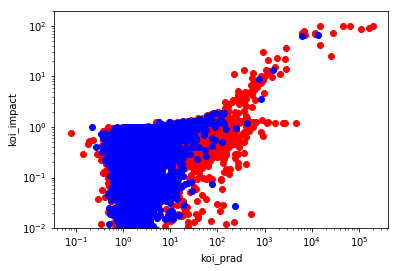

In [35]:
x1 = X['koi_prad'][y['target'] == 0]
y1 = X['koi_impact'][y['target'] == 0]
plt.scatter(x1,y1, c='red')

x1 = X['koi_prad'][y['target'] == 1]
y1 = X['koi_impact'][y['target'] == 1]
plt.scatter(x1,y1, c='blue')

plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-2, 200])
plt.xlabel('koi_prad')
plt.ylabel('koi_impact')

In [36]:
logit_model = sm.Logit(y, X)
result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.522665
         Iterations 9


In [37]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                 9200
Model:                          Logit   Df Residuals:                     9185
Method:                           MLE   Df Model:                           14
Date:                Mon, 24 Jun 2019   Pseudo R-squ.:                  0.2452
Time:                        01:49:06   Log-Likelihood:                -4808.5
converged:                       True   LL-Null:                       -6370.9
                                        LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       17.3796      1.659     10.474      0.000      14.127      20.632
koi_period    1.446e-06   1.54e-05      0.094      0.925   -2.88e-05    3.17e-05
koi_time0bk     -0.0053      0.000    -12.369      0.000      -0.006      -0.004
koi_impact      -0.4560      0.059     -7.731      0.000      -0.572      -0.340
koi_duration    -0.1174      0.007    -17.307      0.000      -0.131      -0.104
koi_depth    -4.788e-05    3.2e-06    -14.949      0.000   -5.42e-05   -4.16e-05
koi_prad         0.0002   3.65e-05      6.015      0.000       0.000       0.000
koi_teq         -0.0014   5.44e-05    -25.592      0.000      -0.001      -0.001
koi_insol     1.813e-06   2.85e-07      6.358      0.000    1.25e-06    2.37e-06
koi_steff    -8.566e-05   4.06e-05     -2.108      0.035      -0.000      -6e-06
koi_slogg       -0.3428      0.107     -3.201      0.001      -0.553      -0.133
koi_srad        -0.0112      0.011     -1.056      0.291      -0.032       0.010
ra              -0.0443      0.005     -8.299      0.000      -0.055      -0.034
dec              0.0430      0.007      6.265      0.000       0.030       0.056
koi_kepmag      -0.0654      0.023     -2.804      0.005      -0.111      -0.020
================================================================================
"""

In [38]:
df.drop(['koi_period', 'koi_srad'], axis=1, inplace=True)

In [39]:
y, X = dmatrices('target ~ koi_time0bk + koi_impact + koi_duration + koi_depth + koi_prad + koi_teq + koi_insol + koi_steff + koi_slogg + ra + dec+ koi_kepmag',
                  df, return_type = "dataframe")
X.head()

,Intercept,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_steff,koi_slogg,ra,dec,koi_kepmag
0,1.0,170.538750,0.146,2.95750,615.8,2.26,793.0,93.59,5455.0,4.467,291.93423,48.141651,15.347
1,1.0,162.513840,0.586,4.50700,874.8,2.83,443.0,9.11,5455.0,4.467,291.93423,48.141651,15.347
2,1.0,175.850252,0.969,1.78220,10829.0,14.60,638.0,39.30,5853.0,4.544,297.00482,48.134129,15.436
3,1.0,170.307565,1.276,2.40641,8079.2,33.46,1395.0,891.96,5805.0,4.564,285.53461,48.285210,15.597
4,1.0,171.595550,0.701,1.65450,603.3,2.75,1406.0,926.16,6031.0,4.438,288.75488,48.226200,15.509


In [40]:
logit_model = sm.Logit(y, X)
result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.522735
         Iterations 9


In [41]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                 9200
Model:                          Logit   Df Residuals:                     9187
Method:                           MLE   Df Model:                           12
Date:                Mon, 24 Jun 2019   Pseudo R-squ.:                  0.2451
Time:                        01:49:07   Log-Likelihood:                -4809.2
converged:                       True   LL-Null:                       -6370.9
                                        LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       17.0358      1.630     10.452      0.000      13.841      20.230
koi_time0bk     -0.0053      0.000    -12.416      0.000      -0.006      -0.004
koi_impact      -0.4557      0.059     -7.729      0.000      -0.571      -0.340
koi_duration    -0.1172      0.007    -17.296      0.000      -0.130      -0.104
koi_depth    -4.788e-05    3.2e-06    -14.951      0.000   -5.42e-05   -4.16e-05
koi_prad         0.0002   3.68e-05      5.950      0.000       0.000       0.000
koi_teq         -0.0014   5.44e-05    -25.595      0.000      -0.001      -0.001
koi_insol     1.692e-06   2.47e-07      6.849      0.000    1.21e-06    2.18e-06
koi_steff    -7.639e-05   3.97e-05     -1.922      0.055      -0.000    1.51e-06
koi_slogg       -0.2679      0.083     -3.232      0.001      -0.430      -0.105
ra              -0.0443      0.005     -8.306      0.000      -0.055      -0.034
dec              0.0431      0.007      6.273      0.000       0.030       0.057
koi_kepmag      -0.0686      0.023     -2.961      0.003      -0.114      -0.023
================================================================================
"""

### K-Nearest Neighbor (KNN) Classification 

In [42]:
def knn_classify(X, y, n_neighbor):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20) 
    scaler = StandardScaler()  
    scaler.fit(X_train)

    X_train = scaler.transform(X_train);
    X_test = scaler.transform(X_test);
    knn = KNeighborsClassifier(n_neighbors=n_neighbor)
    knn.fit(X_train, y_train)
    # make class predictions for the testing set
    y_pred_class = knn.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    print('Accuracy:' + str(accuracy))
    print('F1: ' + str(metrics.f1_score(y_test, y_pred_class)))
    return accuracy

In [43]:
for n in range(1,10):
    print('n =', n)
    knn_classify(X, y, n)
    print('\n')

n = 1
Accuracy:0.7043478260869566
F1: 0.7169614984391258


n = 2
Accuracy:0.725
F1: 0.679340937896071


n = 3
Accuracy:0.7375
F1: 0.7393416082029142


n = 4
Accuracy:0.7402173913043478
F1: 0.721120186697783


n = 5
Accuracy:0.7592391304347826
F1: 0.7649867374005305


n = 6
Accuracy:0.753804347826087
F1: 0.7465025181869054


n = 7
Accuracy:0.7516304347826087
F1: 0.758839050131926


n = 8
Accuracy:0.7423913043478261
F1: 0.7398463227222832


n = 9
Accuracy:0.7597826086956522
F1: 0.7716942148760332




Confusion matrix, without normalization
[[665 257]
 [195 723]]


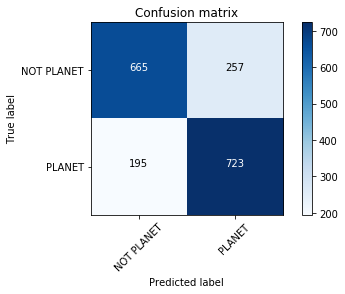

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20) 
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train);
X_test = scaler.transform(X_test);
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
# make class predictions for the testing set
y_pred_class = knn.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred_class)
cf = confusion_matrix(y_test, y_pred_class)
plot_confusion_matrix(cf, ['NOT PLANET', 'PLANET'], normalize=False)


### Support Vector Machine (SVM)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20) 

In [ ]:
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train);  
X_test = scaler.transform(X_test);  

In [ ]:
svclassifier = SVC(kernel='poly')  
svclassifier.fit(X_train, y_train) 

In [ ]:
y_pred = svclassifier.predict(scaler.transform(X_test))

In [ ]:
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred)) 
print("The accuracy score is" + " "+ str(accuracy_score(y_test, y_pred)))

Clusers are not seprable with a hyperplane. 

In [ ]:

cf = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cf, ['FALSE POSITIVE', 'CANDIDATE'], normalize=False)

### What contributes to a planet?

In [48]:
kepler_no_nans = df.dropna(axis=0)

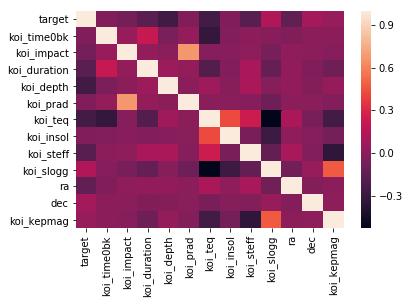

In [49]:
corr = df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)